In [3]:
# 以下程序展示了如何将MNIST输入数据转化为TFRecord格式

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# 生成整数型的属性
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

mnist=input_data.read_data_sets('data/MNIST', dtype=tf.uint8, one_hot=True)

images = mnist.train.images

# 训练数据所对应的正确答案，可以作为一个属性保存在TFRecord中
labels = mnist.train.labels

#训练数据的图像分辨率，可作为Exampla中的一个属性
pixels = images.shape[1]
num_examples = mnist.train.num_examples

# 输出 TFRecord文件地址
filename = 'data/MNIST/TFRecord/output.tfrecords'

# 创建一个writer来写TFRecord文件
writer = tf.python_io.TFRecordWriter(filename)
for index in range(num_examples):
    # 将图像矩阵转化为一个字符串
    image_raw = images[index].tostring()
    # 将一个样本转化为Example Protocol Buffer，并将所有的信息写入这个数据结构
    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels':_int64_feature(pixels),
    'label':_int64_feature(np.argmax(labels[index])),
    'image_raw':_bytes_feature(image_raw)}))
    
    # 将一个Example写入 TFRecord文件
    writer.write(example.SerializeToString())
write.close()

# 以上语句将MNIST数据集中所有训练数据储存到一个TFRecord文件中

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [8]:
# 以下语句将读取TFRecord文件中的数据

import tensorflow as tf

# 创建一个reader读取TFRecord文件中的样本
reader=tf.TFRecordReader()

#创建一个队列维护输入文件列表
filename_queue = tf.train.string_input_producer(['data/MNIST/TFRecord/output.tfrecords'])

# 从文件中读取一个样本，也可以使用使用read_up_to函数一次性读取多个样本
_, serialized_example = reader.read(filename_queue)

# 解析读入的一个样本，或用parse_example函数解析多个样本
# tf.FixedLenFeature得到的解析结果为一个张量，tf.VarLenFeature得到的解析结果为一个sparseTensor，用于处理稀疏数据
features = tf.parse_single_example(serialized_example,
                                  features={
                                      # 这里解析数据的格式需要和上面写入数据的格式一致
                                      'image_raw':tf.FixedLenFeature([], tf.string),
                                      'pixels':tf.FixedLenFeature([], tf.int64),
                                      'label':tf.FixedLenFeature([], tf.int64),
                                  })

# tf.decode_raw可以将字符串解析成图像对应的像素数组
images = tf.decode_raw(features['image_raw'], tf.uint8)
labels = tf.cast(features['label'], tf.int32)
pixels = tf.cast(features['pixels'], tf.int32)

with tf.Session() as sess:
    # 启动多线程处理输入数据
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    # 每次运行可以读取TFRecord文件中的一个样本，当所有样本读完后，将重头开始
    for i in range(10):
        image, label, pixel = sess.run([images, labels, pixels])

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_2/input_producer_2_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_2, input_producer_2/RandomShuffle)]]


### Tensorflow 图像处理函数

[[[ 77  54  38]
  [ 77  54  38]
  [ 78  55  39]
  ..., 
  [ 30  17   9]
  [ 30  17   9]
  [ 30  17   9]]

 [[ 78  55  39]
  [ 78  55  39]
  [ 78  55  39]
  ..., 
  [ 30  17   9]
  [ 30  17   9]
  [ 30  17   9]]

 [[ 79  56  38]
  [ 79  56  38]
  [ 79  56  38]
  ..., 
  [ 30  17   9]
  [ 30  17   9]
  [ 30  17   9]]

 ..., 
 [[122 105  89]
  [122 105  89]
  [122 105  89]
  ..., 
  [211 163 117]
  [211 163 117]
  [211 163 117]]

 [[122 105  89]
  [122 105  89]
  [122 105  89]
  ..., 
  [211 163 117]
  [211 163 117]
  [211 163 117]]

 [[123 106  90]
  [123 106  90]
  [123 106  90]
  ..., 
  [210 162 116]
  [210 162 116]
  [210 162 116]]]


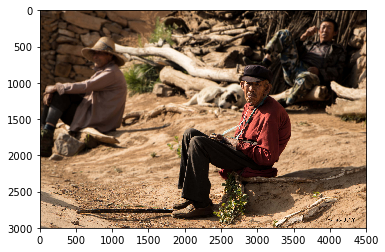

In [1]:
# 图像编码处理
# 图像存储时记录压缩/编码张量后的结果，TensorFlow提供了对jpeg和png格式图片编码/解码函数
# 以下将使用matplotllib可视化经TF处理过的图像
import matplotlib.pyplot as plt
import tensorflow as tf

# 读取图像的原始数据
image_raw_data =  tf.gfile.FastGFile("data/raw_image/11.jpg", "rb").read()

with tf.Session() as sess:
    # 将jpeg图像解码为对应的张量。tf.image.decode_png对png格式图片解码。
    img_data = tf.image.decode_jpeg(image_raw_data)
    print(img_data.eval())
    plt.imshow(img_data.eval())
    plt.show()
    
    # 将表示一张图片的三维矩阵重新按照jpeg编码并存入文件中
    encoded_image = tf.image.encode_png(img_data)
    with tf.gfile.GFile('data/raw_image/22.png', 'wb') as f:
        f.write(encoded_image.eval())

(600, 600, ?)


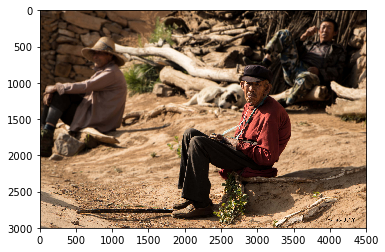

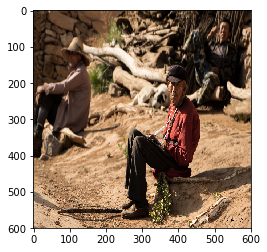

In [17]:
# 调整图像大小，传入神经网络前先将图像大小统一
# TF提供四种方法尽量保存原始图片的所有信息

import tensorflow as tf
import matplotlib.pyplot as plt

image_raw_data = tf.gfile.FastGFile('data/raw_image/11.jpg', 'rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    
    # 通过tf.image.resize_images函数调整图像大小
    # 该函数第一个参数为原始图像，第二和第三个参数为调整后的图像大小(默认深度一致)，method为调整图像的算法
    resized=tf.image.resize_images(img_data, [600, 600], method=1)
    print(resized.get_shape())
    plt.imshow(img_data.eval())
    plt.show()
    plt.imshow(resized.eval())
    plt.show()
    

In [ ]:
# TF 还提供API对图像进行剪裁或填充（修改图像大小）
# 通过tf.image.resize_image_with_crop_or_pad函数调整图像大小。该图像第一个参数为原始图像的张量数据，第二个为目标尺寸
# 若目标尺寸小于原始，则居中剪裁。若原始小于目标，则0填充
croped = tf.image.resize_image_with_crop_or_pad(img_data, 500, 500)
paded = tf.image.resize_image_with_crop_or_pad(img_data, 6000, 6000)

# 以下函数按比例调整图像，第二个参数为调整比例，(0,1]的实数。其它裁剪填充函数见API
central_cropped = tf.image.central_crop(img_data, 0.5)

In [ ]:
# 图像翻转,扩充数据

# 将图片上下翻转
flipped = tf.image.flip_up_down(img_data)
# 将图像左右翻转
flipped = tf.image.flip_left_right(img_data)
# 将图像沿对角线翻转
transposed = tf.image.transpose_image(img_data)

# 随机图像翻转过程
# 以一定概率上下翻转图像
flipped = tf.image.random_flip_up_down(img_data)
# 以一定概率左右翻转
flipped = tf.image.random_flip_left_right(img_data)

In [ ]:
# 图像色彩调整，随机调整图像的亮度、对比度、色相等扩展数据

# 将图像亮度-0.5
adjusted = tf.image.adjust_brightness(img_data, -0.5)
# 将图像亮度+0.5
adjusted = tf.image.adjust_brightness(img_data, 0.5)
# 在[-max_delta, max_delta]范围内随机调整图像亮度
adjusted = tf.image.random_brightness(img_data, max_delta)

# 在{lower, upper}的范围随机调整图的对比度
adjusted = tf.image.random_contrast(image, lower, upper)

# 随机调整图像色相
adjusted = tf.image.random_hue(image, max_delta)

# TF 提供API实现图像的归一化，以下将图像张量的数值均值为0，方差为1
adjusted = tf.image.per_image_whitening(img_data)

In [ ]:
# 处理标注框，以下展示如何在图像中加入标注框

# 将图像缩小，可视化能让标注框更清楚
img_data = tf.image.resize_images(img_data, 600, 400, method=1)

# drow_bounding_boxes函数图像的输入是一个批量的数据。所以需要将解码后的图像张量加一维
batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0)

# 给出每一张图像的所有标注框，一个标注框四个参数代表 [y_min, x_min, y_max, x_max]
# 这里给出的数字都是相对位置
boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
result = tf.image.draw_bounding_boxes(batched, boxes)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 随机调整图片的色彩，定义两种顺序
def distort_color(image, color_ordering=0):
    if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)

    return tf.clip_by_value(image, 0.0, 1.0)

# 对图片进行预处理，将图片转化成神经网络的输入层数据
def preprocess_for_train(image, height, width, bbox):
    # 查看是否存在标注框。
    if bbox is None:
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        
    # 随机的截取图片中一个块。
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox)
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox)
    distorted_image = tf.slice(image, bbox_begin, bbox_size)

    # 将随机截取的图片调整为神经网络输入层的大小。
    distorted_image = tf.image.resize_images(distorted_image, [height, width], method=np.random.randint(4))
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = distort_color(distorted_image, np.random.randint(2))
    return distorted_image

# 读取图片
image_raw_data = tf.gfile.FastGFile("../../datasets/cat.jpg", "r").read()
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    for i in range(9):
        result = preprocess_for_train(img_data, 299, 299, boxes)
        plt.imshow(result.eval())
        plt.show()


### 队列与多线程
TF中队列和变量都是计算图上有状态的结点。修改队列状态的操作主要有Enquwue、EnqueueMany 和 Dequeue。

In [ ]:
# 使用函数操作一个队列
import tensorflow as tf

# 创建一个先进先出的队列，指定队列中最多可以保存两个元素，并指定类型为整数
q = tf.FIFOQueue(2, 'int32')

# 使用enqueue_many函数初始化队列中的元素。与变量初始化类似，在使用队列初始化之前需要明确调用初始化过程。
init = q.enqueue_many(([0, 10], ))

# 使用Dequeue函数将队列中的第一个元素移出队列，并赋值给x
x = q.dequeue()

# 将加1后的值重新加入队列
y = x + 1
q_inc = q.enqueue([y])

with tf.Session() as sess:
    # 运行初始化队列的操作
    init.run()
    for _ in range(5):
        # 运行 q_inc 将执行队列移出、元素加1、重新加入队列
        v, _ =sess.run([x, q_inc])
        print(v)

In [ ]:
# FIFOQueue实现的是先进先出的队列，RandomShuffleQueue会将队列元素扰乱，随机选择一个元素
# TF提供了 tf.Coordinator 和 tf.QueueRunner 完成多线程协同功能
# tf.Coordinator主要协同多个线程一起停止

import tensorflow as tf
import numpy as np
import threading
import time

# 线程中运行的程序，该程序每秒判断是否停止打印自己的ID
def myloop(coord, worker_id):
    # 使用tf.Coordinator 类提供的协同工具判断当前线程是否需要停止
    while not coord.should_stop():
        # 随机停止所有线程
        if np.random.rand() < 0.1:
            print('Stoping from id: %d\n'% worker_id)
            # 调用coord.request_stop()函数通知其它线程停止
        else:
            # 打印当前线程的id
            print('Working on id: %d\n'% worker_id)
        # 暂停一秒
        time.sleep(1)
        
# 声明一个tf.train.Coordinator 类来协同多个线程
coord = tf.train.Coordinator()
#声明创建5个线程
threads=[threading.Thread(target=myloop, args=(coord, i, )) for i in range(5)]
# 启动所有线程
for t in threads: t.start()
# 等待所有线程的退出
coord.join(threads)


In [1]:
# 以下展示如何使用tf.QueueRunner 和 tf.Coordinator 管理多线程队列操作

import tensorflow as tf

# 声明一个先进先出队列
queue = tf.FIFOQueue(100, 'float')
# 定义队列入队操作
enqueue_op = queue.enqueue([tf.random_normal([1])])
# 使用tf.train.QueueRunner 创建多个线程运行队列的入队操作，[enqueue_op]*5代表需要启动5个线程
qr = tf.train.QueueRunner(queue, [enqueue_op]*5)
# 将定义过的QueueRunner加入TF计算图上指定的集合
tf.train.add_queue_runner(qr)
# 定义出队操作
out_tensor = queue.dequeue()

with tf.Session() as sess:
    #协同启动的线程
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # 获取队列中的取值
    for _ in range(3):print(sess.run(out_tensor)[0])
    #停止所有线程
    coord.request_stop()
    coord.join(threads)

0.466539
0.986114
0.474632
